<a href="https://colab.research.google.com/github/tnwls6865/cau_mAI_tutorial/blob/main/Week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10

In [ ]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  (X_train, y_train) , (X_test, y_test) = cifar10.load_data()
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis=0).astype('uint8')
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('dev data shape: ', X_dev.shape)
print ('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000, 1)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000, 1)
Test data shape:  (1000, 3073)
Test labels shape:  (1000, 1)
dev data shape:  (500, 3073)
dev labels shape:  (500, 1)


### Softmax 
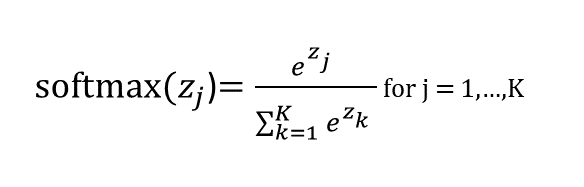

In [ ]:
def softmax_loss_naive(W, X, y, reg):
  """
  Softmax loss function, naive implementation (with loops)

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  # Initialize the loss and gradient to zero.
  N, D = X.shape
  C = W.shape[1]

  loss = 0.0
  out = np.zeros((N,C))
  dW = np.zeros_like(W)  # (3073, 10)

  for i in range(N):
    for j in range(C):
      for k in range(D):
        out[i, j] += X[i, k] * W[k, j]
    out[i, :] = np.exp(out[i, :])
    out[i, :] /= np.sum(out[i, :])  #  (N, C)
  
  # compute loss
  loss -= np.sum(np.log(out[np.arange(N), y])) 
  loss /= N
  loss += 0.5 * reg * np.sum(W**2)
  
  # backward
  out[np.arange(N), y] -= 1   # (N, C)
 
  for i in range(N):
    for j in range(D):
      for k in range(C):
        dW[j, k] += X[i, j] * out[i, k] 

  # add reg term
  dW /= N
  dW += reg * W
  
  return loss, dW

In [ ]:

def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.

  Inputs and outputs are the same as softmax_loss_naive.
  """
  # Initialize the loss and gradient to zero.
  N = X.shape[0]
  loss = 0.0
  dW = np.zeros_like(W)
  
  # forward
  score = np.dot(X, W)   # (N, C)
  out = np.exp(score)
  out /= np.sum(out, axis=1, keepdims=True)   # (N, C)
  loss -= np.sum(np.log(out[np.arange(N), y]))
  loss /= N
  loss += 0.5 * reg * np.sum(W**2)

  # backward
  dout = np.copy(out)   # (N, C)
  dout[np.arange(N), y] -= 1
  dW = np.dot(X.T, dout)  # (D, C)
  dW /= N
  dW += reg * W

  return loss, dW

In [ ]:
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev.flatten(), 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print ('loss: %f' % loss )
print ('sanity check: %f' % (-np.log(0.1)) )

loss: 2.746875
sanity check: 2.302585


In [ ]:
loss, grad = softmax_loss_vectorized(W, X_dev, y_dev.flatten(), 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print ('loss: %f' % loss )
print ('sanity check: %f' % (-np.log(0.1)) )

loss: 2.746875
sanity check: 2.302585


### Training Nueral Network
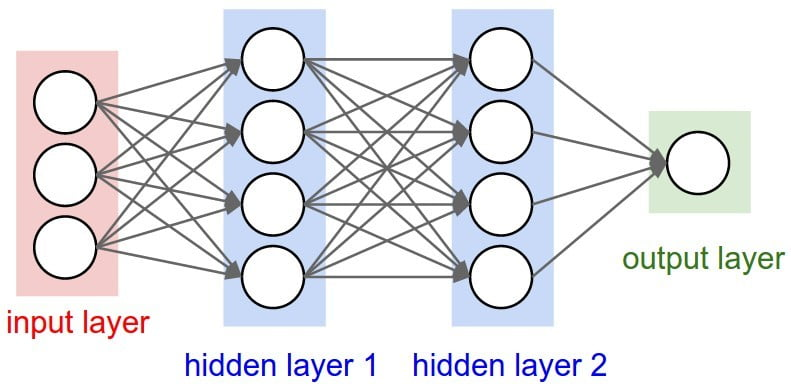

In [ ]:
class TwoLayerNet(object):
  """
  
  input - fully connected layer - ReLU - fully connected layer - softmax

  """

  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    """

    W1: First layer weights; has shape (D, H)
    b1: First layer biases; has shape (H,)
    W2: Second layer weights; has shape (H, C)
    b2: Second layer biases; has shape (C,)

    Inputs:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
    """
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = std * np.random.randn(hidden_size)  + 0.5  # np.zeros(hidden_size) 
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def loss(self, X, y=None, reg=0.0):
    
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape

    # Compute the forward pass
    scores = None
    
    z = np.dot(X, W1) + b1  # (N, num_hidden)
    h = np.maximum(z, 0)    # ReLU
    scores = np.dot(h , W2) + b2 

    if y is None:
      return scores

    # Compute the loss
    loss = 0.0
  
    # compute softmax probabilities
    out = np.exp(scores)      # (N, C)
    out /= np.sum(out, axis=1).reshape(N, 1)
    
    # compute softmax loss
    loss -= np.sum(np.log(out[np.arange(N), y]))
    loss /= N
    loss += 0.5 * reg * (np.sum(W1**2) + np.sum(W2**2))
    
    # Backward pass : gradient계산
    grads = {}

    # back propagation
    dout = np.copy(out)  # (N, C)
    dout[np.arange(N), y] -= 1
    dh = np.dot(dout, W2.T)
    dz = np.dot(dout, W2.T) * (z > 0)  # (N, H)
    
    # compute gradient for parameters
    grads['W2'] = np.dot(h.T, dout) / N      # (H, C)
    grads['b2'] = np.sum(dout, axis=0) / N      # (C,)
    grads['W1'] = np.dot(X.T, dz) / N        # (D, H)
    grads['b1'] = np.sum(dz, axis=0) / N       # (H,)
    
    # add reg term
    grads['W2'] += reg * W2
    grads['W1'] += reg * W1

    return loss, grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
  
    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      X_batch = None
      y_batch = None
        
      random_idxs = np.random.choice(num_train, batch_size)
      X_batch = X[random_idxs]
      y_batch = y[random_idxs]
    
      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)

      
      self.params['W2'] -= learning_rate * grads['W2']
      self.params['b2'] -= learning_rate * grads['b2']
      self.params['W1'] -= learning_rate * grads['W1']
      self.params['b1'] -= learning_rate * grads['b1']
        

      if verbose and it % 100 == 0:
        print ('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
   
    y_pred = None
    params = self.params
        
    z = np.dot(X, params['W1']) + params['b1']
    h = np.maximum(z, 0)
    out = np.dot(h, params['W2']) + params['b2']
    y_pred = np.argmax(out, axis=1)

    return y_pred


In [ ]:

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
  np.random.seed(0)
  return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
  np.random.seed(1)
  X = 10 * np.random.randn(num_inputs, input_size)
  y = np.array([0, 1, 2, 2, 1])
  return X, y

net = init_toy_model()
X, y = init_toy_data()

In [ ]:
scores = net.loss(X)
print ('Your scores:')
print (scores)

print ('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print (correct_scores)


# The difference should be very small. We get < 1e-7
print ('Difference between your scores and correct scores:')
print (np.sum(np.abs(scores - correct_scores)))
     

Your scores:
[[-0.88723152 -0.67804916 -0.54064941]
 [-0.73413472 -1.37884814 -0.28698463]
 [-0.6511989  -1.38140079 -0.54543061]
 [-0.30624167 -0.73730537 -0.30047893]
 [-0.05588198  0.07682239 -0.15976916]]
correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]
Difference between your scores and correct scores:
3.4739848849416273


Final training loss:  0.014880025252082832


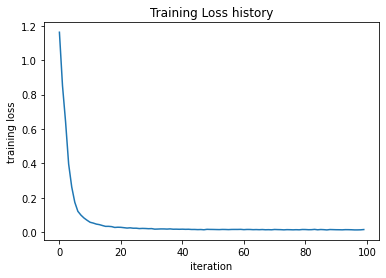

In [ ]:

net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=1e-5,
            num_iters=100, verbose=False)

print ('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

In [ ]:


def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
   
    # Load the raw CIFAR-10 data
    (X_train, y_train) , (X_test, y_test) = cifar10.load_data()
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0).astype('uint8')
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print ('Train data shape: ', X_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000, 1)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000, 1)
Test data shape:  (1000, 3072)
Test labels shape:  (1000, 1)


In [ ]:

input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train.flatten(), X_val, y_val.flatten(),
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.5, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val.flatten()).mean()
print ('Validation accuracy: ', val_acc)


iteration 0 / 1000: loss 2.302981
iteration 100 / 1000: loss 2.301378
iteration 200 / 1000: loss 2.289367
iteration 300 / 1000: loss 2.221870
iteration 400 / 1000: loss 2.179891
iteration 500 / 1000: loss 2.175956
iteration 600 / 1000: loss 2.146093
iteration 700 / 1000: loss 2.162762
iteration 800 / 1000: loss 2.159223
iteration 900 / 1000: loss 2.140181
Validation accuracy:  0.241


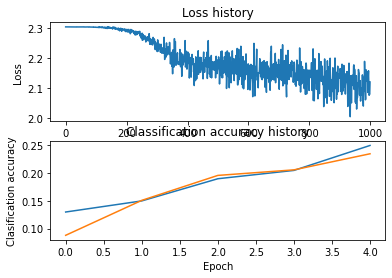

In [ ]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

### TODO : Neural Network hyperparameter 변경해서 학습하고 어떻게 결과가 나오는지 확인해보기

1. learning rate

In [ ]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train.flatten(), X_val, y_val.flatten(),
            num_iters=1000, batch_size=200,
            learning_rate=0.1, learning_rate_decay=0.95,
            reg=0.5, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val.flatten()).mean()
print ('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.302943


<ipython-input-2-d7fd0aa3e04d>:47: RuntimeWarning: overflow encountered in exp
  out = np.exp(scores)      # (N, C)
<ipython-input-2-d7fd0aa3e04d>:48: RuntimeWarning: invalid value encountered in true_divide
  out /= np.sum(out, axis=1).reshape(N, 1)
<ipython-input-2-d7fd0aa3e04d>:51: RuntimeWarning: divide by zero encountered in log
  loss -= np.sum(np.log(out[np.arange(N), y]))


iteration 100 / 1000: loss nan
iteration 200 / 1000: loss nan
iteration 300 / 1000: loss nan
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
Validation accuracy:  0.087


2. hidden size

In [ ]:
input_size = 32 * 32 * 3
hidden_size = 1000
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train.flatten(), X_val, y_val.flatten(),
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.5, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val.flatten()).mean()
print ('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.310268
iteration 100 / 1000: loss 2.299013
iteration 200 / 1000: loss 2.251251
iteration 300 / 1000: loss 2.156682
iteration 400 / 1000: loss 2.181361
iteration 500 / 1000: loss 2.093502
iteration 600 / 1000: loss 2.159952
iteration 700 / 1000: loss 2.036243
iteration 800 / 1000: loss 2.065397
iteration 900 / 1000: loss 2.007617
Validation accuracy:  0.262


### Batch Normalization

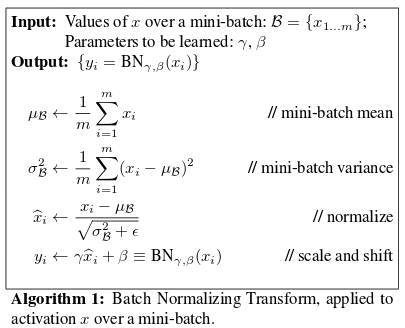

In [ ]:
# Simulate the forward pass for a two-layer network
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1) #200, 50
W1 = np.random.randn(D1, D2) # 50, 60
W2 = np.random.randn(D2, D3) # 60, 3
a = np.maximum(0, X.dot(W1)).dot(W2)

In [ ]:
print ('Before batch normalization:')
print ('  means: ', a.mean(axis=0))
print ('  stds: ', a.std(axis=0))

Before batch normalization:
  means:  [-26.33946855  44.75959592 -19.57883718]
  stds:  [27.46737151 29.23956283 32.38121869]


In [ ]:
def batchnorm_forward(x, gamma, beta, bn_param):
  """
  훈련 중에 샘플 평균과 (보정되지 않은) 샘플 분산은 미니 배치 통계에서 계산되어 들어오는 데이터를 정규화하는 데 사용된다.
  훈련 중에 우리는 또한 각 특징의 평균과 분산에 대한 기하급수적으로 감소하는 실행 평균을 유지하며, 이러한 평균은 테스트 시간에 데이터를 정규화하는 데 사용된다.

  각 timestep에서 momentum parameter에 기초한 exponential decay를 사용하여 평균 및 분산의 running averages을 업데이트합니다:

  """
  mode = bn_param['mode']
  eps = bn_param.get('eps', 1e-5)
  momentum = bn_param.get('momentum', 0.9)

  N, D = x.shape
  running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
  running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

  batch_mean = np.sum(x, axis=0) / N   # mean for each feature in batch data 
  batch_var = np.var(x, axis=0)        # variance for each feature in batch data
  running_mean = momentum * running_mean + (1 - momentum) * batch_mean
  running_var = momentum * running_var + (1 - momentum) * batch_var
  batch_var += eps 
  out, cache = None, None
  
  if mode == 'train':

    batch_norm_x = np.divide(x - batch_mean, np.sqrt(batch_var + eps))
    out = gamma * batch_norm_x + beta
    cache = (x, batch_norm_x, batch_mean, batch_var, gamma, beta, bn_param)

  elif mode == 'test':
    batch_norm_x = np.divide(x - running_mean, np.sqrt(running_var +  eps))
    out = gamma * batch_norm_x + beta
    
  else:
    raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

  # Store the updated running means back into bn_param
  bn_param['running_mean'] = running_mean
  bn_param['running_var'] = running_var

  return out, cache

In [ ]:
print ('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print ('  mean: ', a_norm.mean(axis=0))
print ('  std: ', a_norm.std(axis=0))

After batch normalization (gamma=1, beta=0)
  mean:  [-2.72004641e-17  3.55271368e-17  1.82909243e-16]
  std:  [0.99999999 0.99999999 0.99999999]


In [ ]:
import torch
import torch.nn as nn

m = nn.BatchNorm2d(100)
m2 = nn.BatchNorm2d(100, affine=False)
input = torch.randn(20, 100, 35, 45)
output = m(input)
output2 = m2(input)
print(output)
print(output2)

tensor([[[[ 7.8010e-01, -1.0889e+00,  1.1749e+00,  ...,  3.3659e-01,
            1.9906e-01, -1.0571e+00],
          [-8.0211e-01, -4.2986e-01, -7.7994e-01,  ..., -7.9837e-01,
           -1.4729e+00, -1.8858e+00],
          [ 6.5484e-01, -1.4466e+00, -1.5199e-01,  ..., -8.8653e-01,
           -2.0368e-01, -7.0685e-01],
          ...,
          [-8.8937e-01,  6.6545e-02, -6.8441e-01,  ...,  2.4161e+00,
            2.8845e-01, -7.4469e-01],
          [-5.8566e-02, -4.8359e-02, -5.4505e-01,  ...,  5.3813e-01,
            2.6874e-01, -1.1264e+00],
          [ 6.2115e-01, -7.6251e-01, -1.6238e-01,  ..., -1.2919e+00,
           -1.5447e+00, -2.9363e-01]],

         [[ 2.9095e-01, -6.6511e-01, -1.1241e-01,  ..., -1.4139e+00,
            3.2384e-01,  2.6529e-01],
          [-9.9565e-01, -1.1811e+00, -3.6637e-01,  ...,  1.3487e+00,
            8.5762e-01, -6.7006e-01],
          [ 4.2867e-01, -2.1004e+00, -1.5425e-01,  ...,  7.9765e-01,
            8.3144e-01, -8.6677e-01],
          ...,
     

### Convolution operation

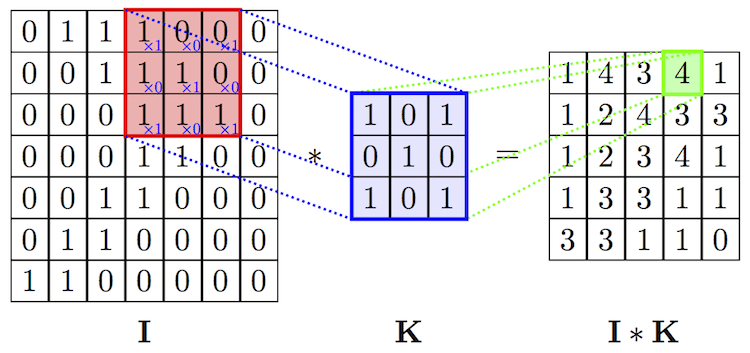

#### Padding 
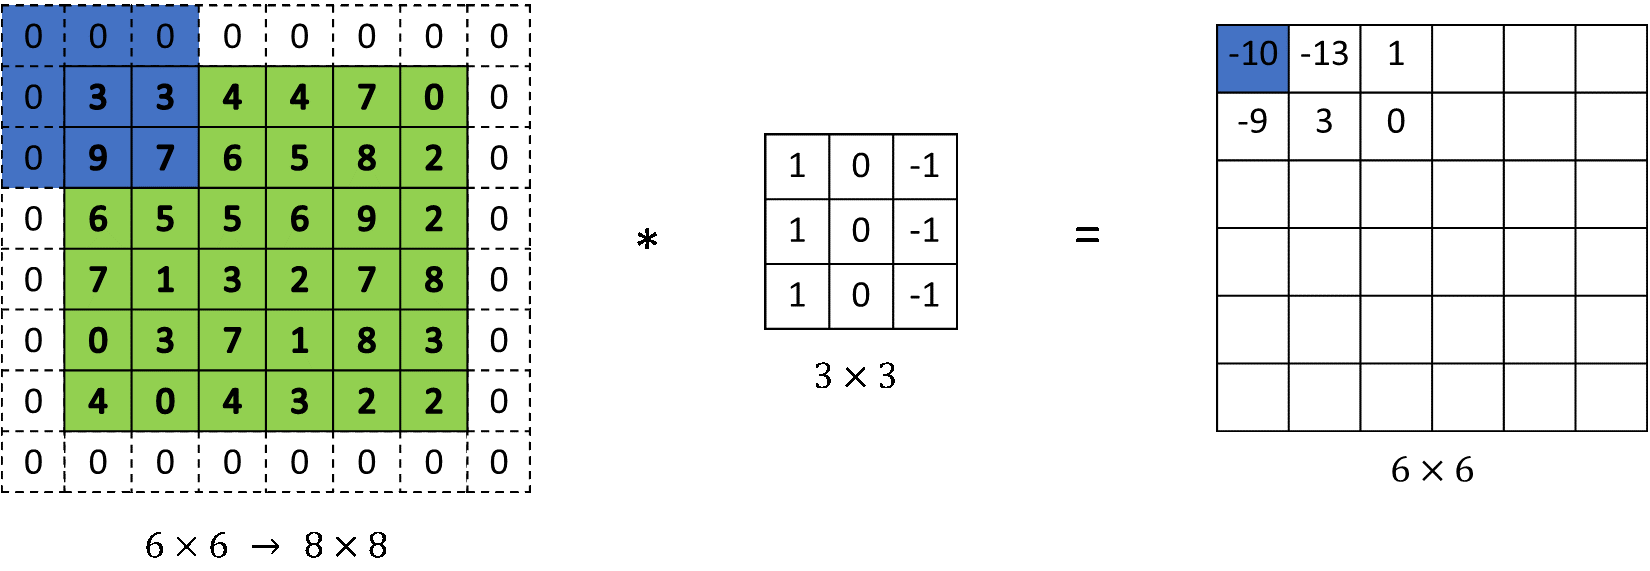

#### Stride 
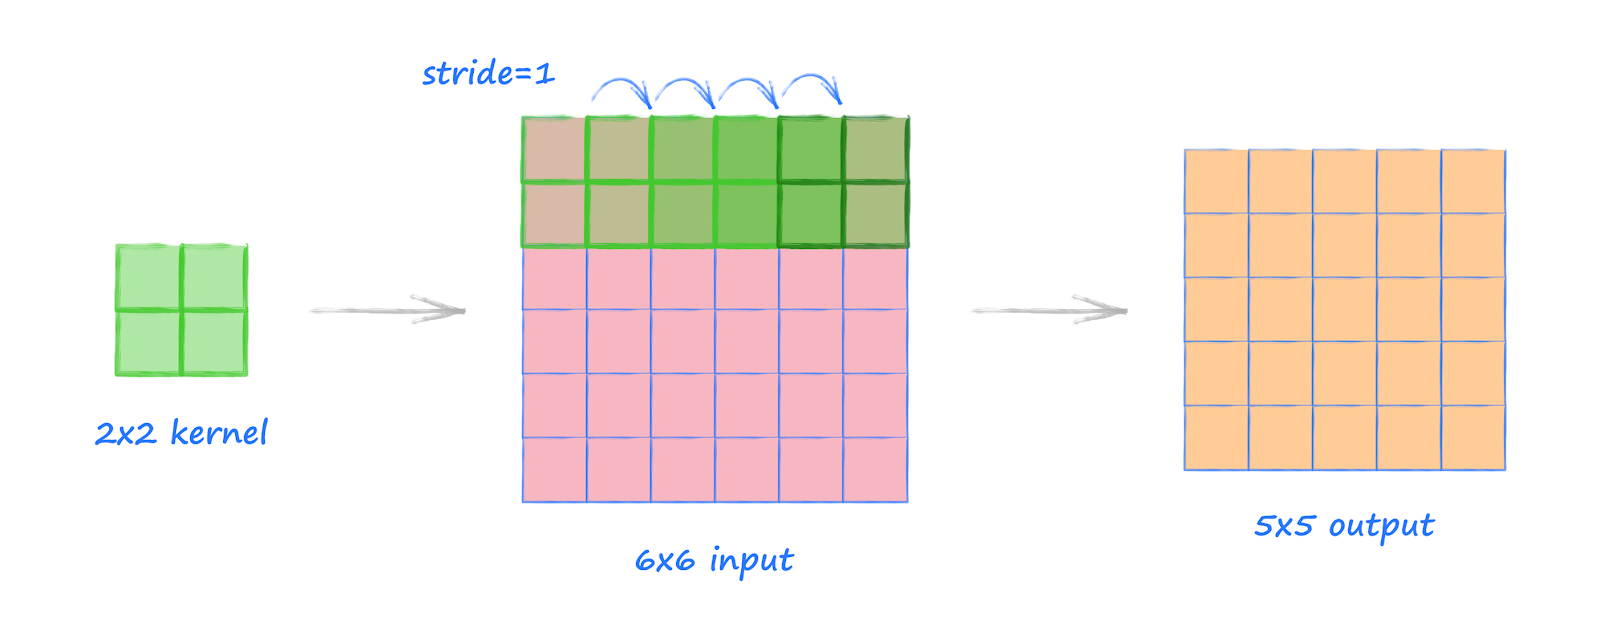

In [ ]:
def conv_forward_naive(x, w, b, conv_param):
  """
  A naive implementation of the forward pass for a convolutional layer.

  The input consists of N data points, each with C channels, height H and width W. We convolve each input with F different filters, where each filter spans
  all C channels and has height HH and width HH.

  Input:
  - x: Input data of shape (N, C, H, W)
  - w: Filter weights of shape (F, C, HH, WW)
  - b: Biases, of shape (F,)
  - conv_param: A dictionary with the following keys:
    - 'stride': The number of pixels between adjacent receptive fields in the
      horizontal and vertical directions.
    - 'pad': The number of pixels that will be used to zero-pad the input.

  Returns a tuple of:
  - out: Output data, of shape (N, F, H', W') where H' and W' are given by
    H' = 1 + (H + 2 * pad - HH) / stride
    W' = 1 + (W + 2 * pad - WW) / stride
  - cache: (x, w, b, conv_param)
  """

  N, C, H, W = x.shape
  K, _, F, _ = w.shape
  S = conv_param['stride']
  P = conv_param['pad']
  H_out = (H - F + 2 * P) / S + 1
  W_out = (W - F + 2 * P) / S + 1
  H_out = int(H_out)
  W_out = int(W_out)
  out = np.zeros((N, K, H_out, W_out))
  
  x_pad = np.pad(x, ((0, 0), (0, 0), (P, P), (P, P)), mode='constant') 
  
  for i in range(N):
      image = x_pad[i, :, : ,:]
      for j in range(K):
          for k in range(H_out):
              for l in range(W_out):
                  image_patch = image[:, (k*S):(k*S + F), (l*S):(l*S + F)]
                  out[i, j, k, l] = np.sum(np.multiply(image_patch, w[j, :, :, :])) + b[j]


  cache = (x, w, b, conv_param)
  return out, cache

In [ ]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)

Output size
(N - F + 2 * P) / S + 1  
N : data size  
P : padding  
F : filter size  
S : stride  

In [ ]:
x.shape

(2, 3, 4, 4)

In [ ]:
out.shape

(2, 3, 2, 2)

In [ ]:
m = nn.Conv2d(16, 33, 3, stride=2)

input = torch.randn(20, 16, 24, 24)
output = m(input)

In [ ]:
output.shape

torch.Size([20, 33, 11, 11])

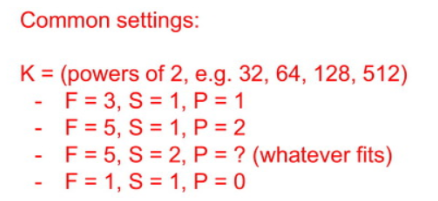

### Pytorch

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


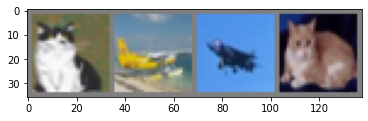

cat   plane plane cat  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [4]:
import torch.optim as optim
import torch.nn as nn


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

NameError: ignored

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.206
[1,  4000] loss: 1.862
[1,  6000] loss: 1.691
[1,  8000] loss: 1.596
[1, 10000] loss: 1.540
[1, 12000] loss: 1.467
[2,  2000] loss: 1.392
[2,  4000] loss: 1.366
[2,  6000] loss: 1.354
[2,  8000] loss: 1.303
[2, 10000] loss: 1.280
[2, 12000] loss: 1.298
Finished Training


In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

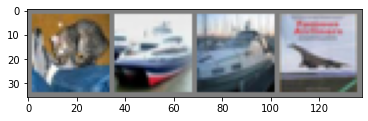

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  ship  ship  ship  ship 


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 64.4 %
Accuracy for class: car   is 66.5 %
Accuracy for class: bird  is 48.9 %
Accuracy for class: cat   is 41.3 %
Accuracy for class: deer  is 35.0 %
Accuracy for class: dog   is 23.8 %
Accuracy for class: frog  is 65.6 %
Accuracy for class: horse is 57.5 %
Accuracy for class: ship  is 75.0 %
Accuracy for class: truck is 70.4 %


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.batch1 = nn.BatchNorm2d(6)

        self.conv2 = nn.Conv2d(6, 16, 5)
        self.batch2 = nn.BatchNorm2d(16)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.batch1(self.conv1(x))))

        x = self.pool(F.relu(self.batch2(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.308
[1,  4000] loss: 2.310
[1,  6000] loss: 2.309
[1,  8000] loss: 2.307
[1, 10000] loss: 2.309
[1, 12000] loss: 2.310
[2,  2000] loss: 2.309
[2,  4000] loss: 2.307
[2,  6000] loss: 2.309
[2,  8000] loss: 2.309
[2, 10000] loss: 2.310
[2, 12000] loss: 2.309
Finished Training


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %


### Transfer learning

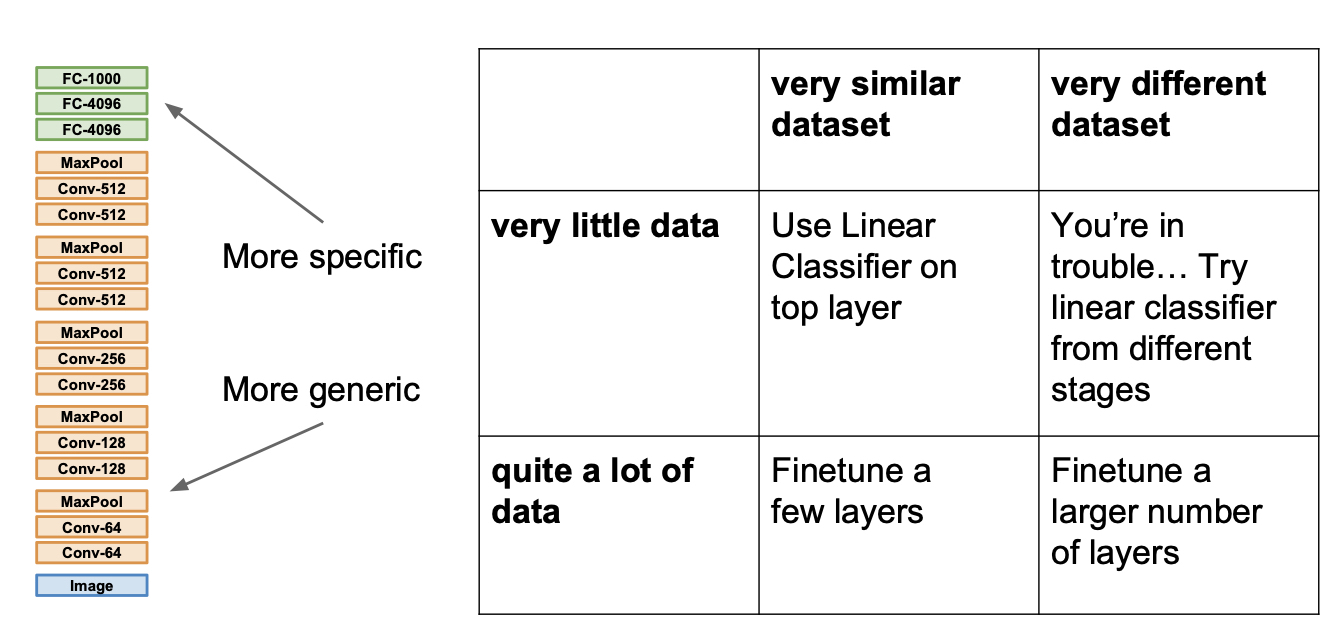

In [ ]:
net.load_state_dict(torch.load(PATH))

RuntimeError: ignored

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
torch.load(PATH).keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])

In [ ]:
net.fc3 = nn.Linear(84, 100)

In [ ]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=100, bias=True)
)

#### VGG Network
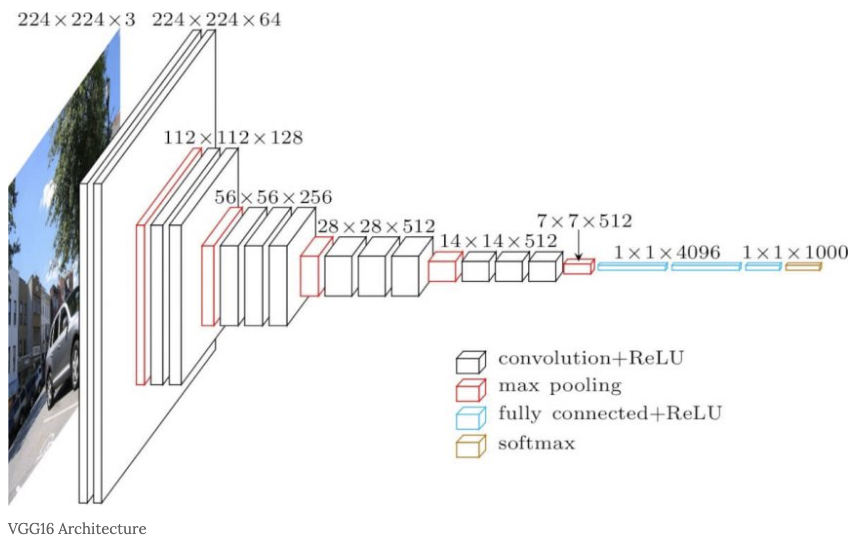

In [5]:
from torchvision.models import vgg16

In [6]:
model = vgg16()

In [7]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
import torch.optim as optim
import torch.nn as nn


criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [10]:
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.465
[1,  4000] loss: 2.041
[1,  6000] loss: 1.826
[1,  8000] loss: 1.715
[1, 10000] loss: 1.614
[1, 12000] loss: 1.530
[2,  2000] loss: 1.401
[2,  4000] loss: 1.308
[2,  6000] loss: 1.269
[2,  8000] loss: 1.188
[2, 10000] loss: 1.144
[2, 12000] loss: 1.098
Finished Training


In [32]:
model2 = vgg16(weights='IMAGENET1K_V1')

In [34]:
model2

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [36]:
model2.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
model2.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [37]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data

        images = images.cuda()
        labels = labels.cuda()
        # calculate outputs by running images through the network
        outputs = model2(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        # print(predicted)
        total += labels.size(0)
        # print(predicted)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 9 %


In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')